# Feature Selection
- Due to many features we have gathered from Feature Engineering, we need to conduct Feature Selection before proceeding to the training of the models. Consequently, this helps to:
1.   Reduce Overfitting: Less redundant data means less opportunity for the model to make decisions based on noise.
2.   Improve Accuracy: Removing misleading or irrelevant features can lead to a more accurate model.
3.   Reduce Training Time: Fewer data points reduce algorithm complexity and training time.
4.   Enhance Generalization: By eliminating unimportant variables, models are
better generalized and less sensitive to variations in the data not related to the output.
5.   Reduce Dimensionality: This mitigates the curse of dimensionality, reducing noise by removing irrelevant features, improving model performance by focussing on more important features

# 1. Combination of CSVs
- Due to the sheer size of the dataset (a total of 9 tweet data sets), we had to run the Feature Engineering script for each of the 9 tweet data sets and obtain the relevant information required from each dataset.
- After which, we are able to concatenate them into two csv files `graph.csv` and `user.csv`.

## 1.1 Importing Dependencies

In [ ]:
import pandas as pd
from pymongo import MongoClient
import csv
import numpy as np
import matplotlib.pyplot as plt

## 1.2 Accessing all the relevant user information from the respective CSVs

In [ ]:
'''
user_0 = pd.read_csv('user_0.csv')
user_1 = pd.read_csv('user_1.csv')
user_2 = pd.read_csv('user_2.csv')
user_3 = pd.read_csv('user_3.csv')
user_4 = pd.read_csv('user_4.csv')
user_5 = pd.read_csv('user_5.csv')
user_6 = pd.read_csv('user_6.csv')
user_7 = pd.read_csv('user_7.csv')
user_8 = pd.read_csv('user_8.csv')
'''

In [ ]:
#Stacking the CSVs together
'''
users = pd.concat([user_0,
                user_1,
                user_2,
                user_3,
                user_4,
                user_5,
                user_6,
                user_7,
                user_8])
'''

## 1.3 Aggregating all duplicate users within the sampling procedure

In [ ]:
'''
#Aggregate all duplicate users within each sampling procedure
log = {col: 'mean' if users[col].dtype in ['float64', 'int64'] and users[col] != 'source_user_id' else 'first' for col in users.columns if col != 'source_user_id'}

users_result = users.groupby('source_user_id').agg(log).reset_index()
'''

In [ ]:
'''
users_result["label"].value_counts()
'''

label
0.0    59769
1.0    49656
Name: count, dtype: int64

## 1.4 Accessing all the relevant graph information from the respective CSVs

In [ ]:
'''
#Concatenate all tweet relationships

graph_0 = pd.read_csv('graph_0.csv')
graph_1 = pd.read_csv('graph_1.csv')
graph_2 = pd.read_csv('graph_2.csv')
graph_3 = pd.read_csv('graph_3.csv')
graph_4 = pd.read_csv('graph_4.csv')
graph_5 = pd.read_csv('graph_5.csv')
graph_6 = pd.read_csv('graph_6.csv')
graph_7 = pd.read_csv('graph_7.csv')
graph_8 = pd.read_csv('graph_8.csv')
'''

In [ ]:
'''
#Stacking the tweet CSVs together

graph = pd.concat([graph_0,
                graph_1,
                graph_2,
                graph_3,
                graph_4,
                graph_5,
                graph_6,
                graph_7,
                graph_8])

                '''

## 1.5 Save user data and graph data in CSV

In [ ]:
'''
users_result.to_csv("users.csv", index = False)
graph.to_csv("graph.csv", index = False)
'''

# 2. Feature Selection

Permutation Importance:
- Permutation Importance works by shuffling random values for each feature in the dataset while keeping other features constant. At each step (feature), the performance of the model is compared to the original baseline performance. The degradation in performance indicates the importance of feature specific to the model. ie. a significant drop in performance suggests that the model relies heavily on this feature to make predictions. Consequently, this feature is considered important.

Impurity Decrease:
* Impurity decrease in Random Forest measures the reduction in impurity, such as Gini impurity or entropy, at each decision tree node when splitting based on a particular feature, compared to the impurity before the split. A higher reduction indicates that the feature contributes more to the overall decision-making process of the model, implying its importance in predictive accuracy.

We utilize Permutation Importance with Random Forest and XGBoost, as well as calculating the impurity decrease in Random Forest to select the most relevant features. By selecting the overlapping features among these three methods, we ensure robustness and prioritize features with consistent importance across multiple techniques, thereby enhancing the reliability of our feature selection process.

## 2.1 Import dependencies


In [3]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

## 2.2 Load the dataset

In [5]:
from google.colab import drive
# drive.mount('/content/drive')
users_df = pd.read_csv("users.csv")

## 2.3 Split into Features and Label


In [7]:
# Only keep numeric columns
numeric_columns = users_df.select_dtypes(include=['number'])

df = users_df[numeric_columns.columns]
Y_set = df['label']
X_set = df.drop(columns=['label'])

# Fill NaN values to 0
X_set.fillna(0, inplace=True)

# 2.4 Testing for Correlation
Including highly correlated features increases model complexity without adding further information to the model. Furthermore, the redundant features may act as additional noise to the data, increasing the risk of overfitting.  

Considering the features being derived through feature engineering, we compute the correlation matrix to check for highly correlated features, these features should be omitted from the eventual model training so as to reduce dimensionality and to mitigate the risk of overfitting.

We set the threshold to be 0.8, focussing only on strongly correlated features

In [8]:
# Compute correlation matrix
correlation_matrix = X_set.corr()

# Filter correlations greater than 0.80
high_correlations = correlation_matrix[(correlation_matrix > 0.80) & (correlation_matrix < 1.0)]

printed = False
# Print correlations greater than 0.80
for column in high_correlations:
    correlated_features = high_correlations[column].dropna()
    for index, correlation in correlated_features.items():
        printed = True
        print(f"{column} - {index}: {correlation:.2f}")

if (printed == False):
    print("No correlations greater than 0.80")

No correlations greater than 0.80


## 2.5 Random Forest (Random Permutation)

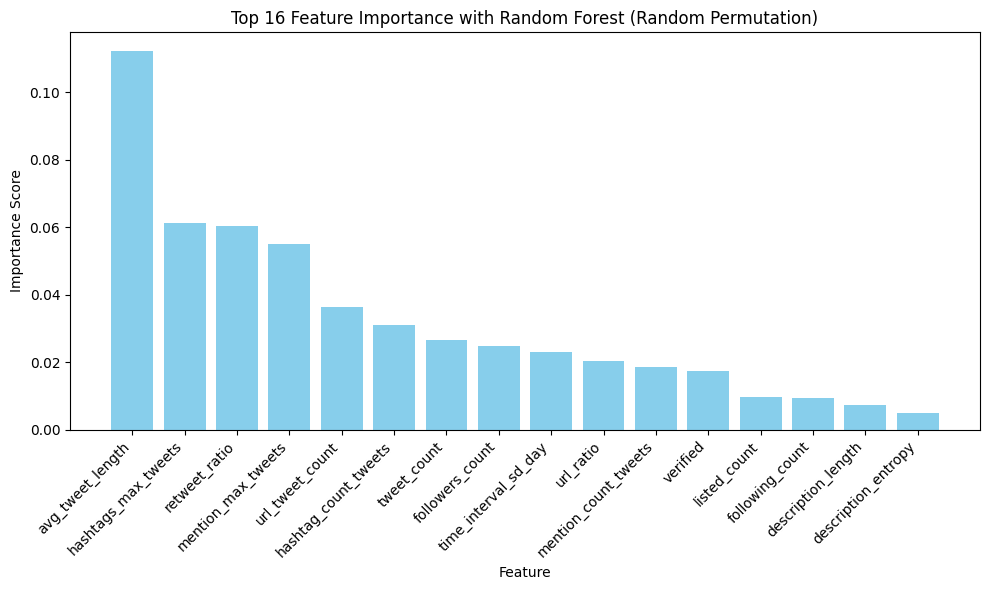

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_set, Y_set)

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_names = X_set.columns
importance_scores = perm_importance.importances_mean

# Get feature importance scores
feature_names = X_set.columns
importance_scores = perm_importance.importances_mean

# Rank features based on importance scores
sorted_idx = np.argsort(importance_scores)[::-1]

# Plot top 16 feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(16), importance_scores[sorted_idx][:16], color='skyblue')
plt.xticks(range(16), feature_names[sorted_idx][:16], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 16 Feature Importance with Random Forest (Random Permutation)')
plt.tight_layout()
plt.show()

## 2.6 Random Forest (Impurity test)

Index(['source_user_id', 'verified', 'url.urls', 'description.urls',
       'description.mentions', 'description.hashtags', 'description.cashtags',
       'followers_count', 'following_count', 'tweet_count', 'listed_count',
       'username_length', 'name_length', 'description_length',
       'numDigits_username', 'username_entropy', 'description_entropy',
       'names_similarity', 'names_ratio', 'reputation', 'age_of_account',
       'retweet_ratio', 'url_count_tweets', 'url_ratio', 'url_max_tweets',
       'time_interval_sd_day', 'mention_count_tweets', 'mention_max_tweets',
       'hashtag_count_tweets', 'hashtags_max_tweets', 'avg_tweet_length',
       'url_tweet_count'],
      dtype='object')


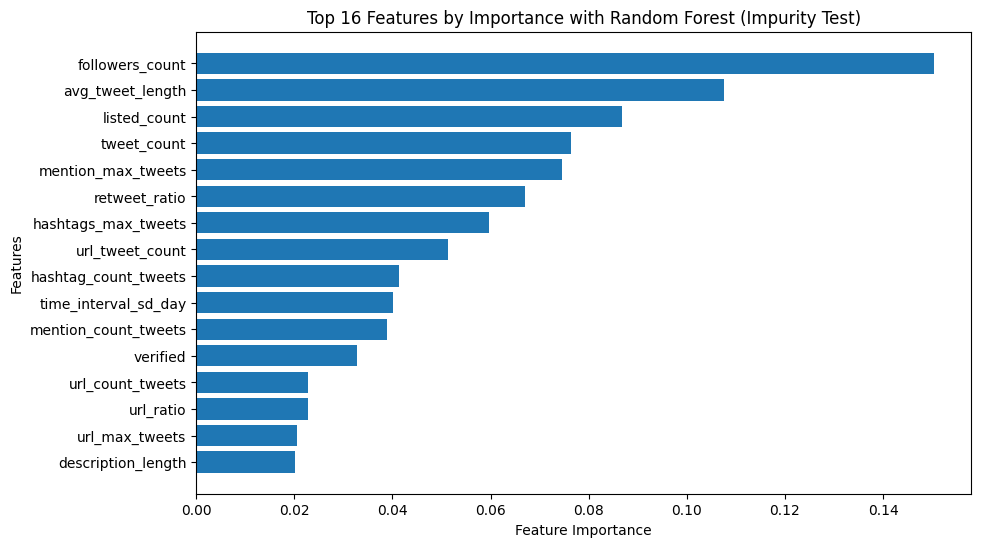

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
print(X_set.columns)
# Calculate how much each feature reduces Gini Impurity to determine feature importance
feature_importances = rf_classifier.feature_importances_
top_indices = np.argsort(feature_importances)[-16:]

# Get top 10 feature importances and column names
top_feature_importances = feature_importances[top_indices]
top_features = X_set.columns[top_indices]

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_importances)), top_feature_importances, tick_label=top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 16 Features by Importance with Random Forest (Impurity Test)')
plt.show()

## 2.7 XGBoost (Random Permutation)

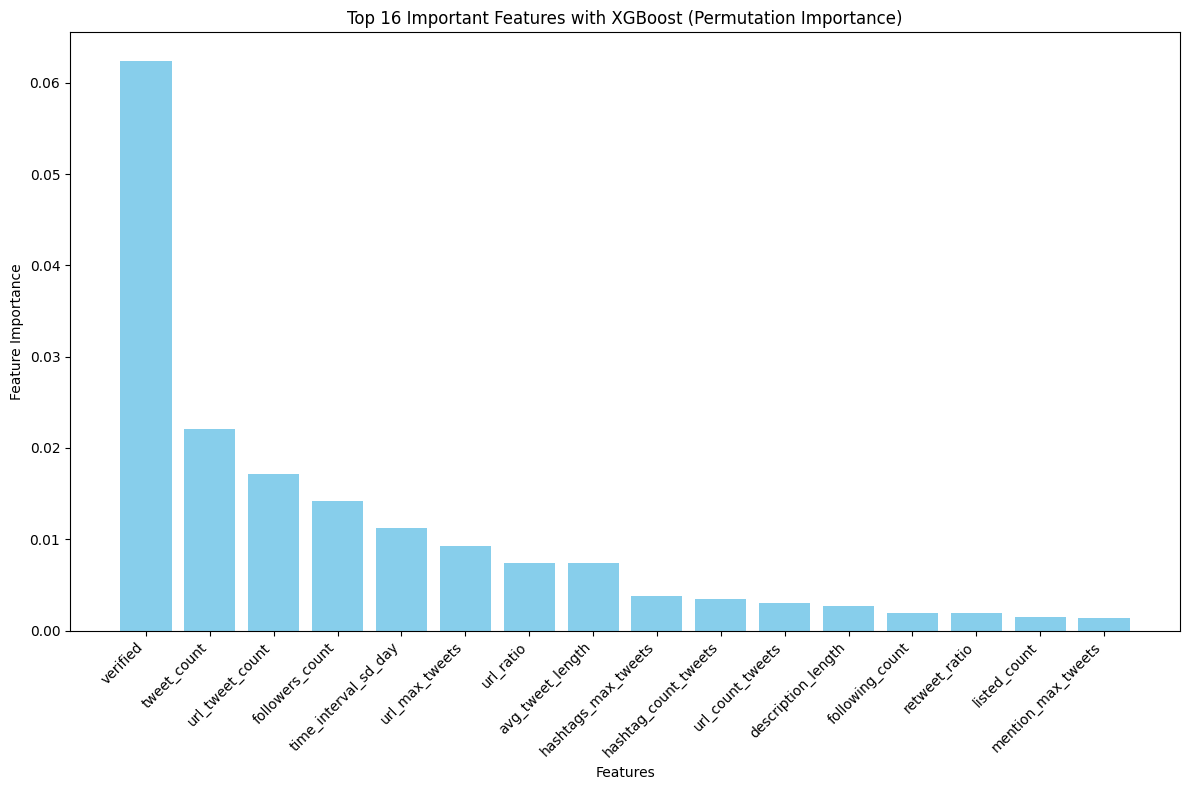

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)

# Training the XGBoost Classifier
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Computing Permutation Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importance scores and names
feature_names = X_set.columns
importance_scores = perm_importance.importances_mean

# Get indices of top 16 features based on permutation importance
top_16_idx = np.argsort(importance_scores)[::-1][:16]

top_16_features = [feature_names[i] for i in top_16_idx]
top_16_importance = importance_scores[top_16_idx]

# Plotting top 16 feature importances
plt.figure(figsize=(12, 8))  # Adjust the figure size for vertical bars
plt.bar(range(len(top_16_features)), top_16_importance, color='skyblue')
plt.xticks(range(len(top_16_features)), top_16_features, rotation=45, ha='right')  # Rotate the feature names for better readability
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Top 16 Important Features with XGBoost (Permutation Importance)')
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()


## 2.8 Finding Common Important Features among all 3 Models

We utilize Permutation Importance with Random Forest and XGBoost, as well as
calculating the impurity decrease in Random Forest to select the most relevant features. By selecting the overlapping features among these three methods, we ensure robustness and prioritize features with consistent importance across multiple techniques, thereby enhancing the reliability of our feature selection process.

In [12]:
rf_perm_top = feature_names[sorted_idx][:16]
xg_perm_top = top_16_features
rf_impurity_top = top_features

In [13]:
repeat_top = []
for items in rf_perm_top:
  if items in xg_perm_top:
    if items in rf_impurity_top:
      repeat_top.append(items)

In [14]:
print("List of Common Important Features across 3 methods")
repeat_top

List of Common Important Features across 3 methods


['avg_tweet_length',
 'hashtags_max_tweets',
 'retweet_ratio',
 'mention_max_tweets',
 'url_tweet_count',
 'hashtag_count_tweets',
 'tweet_count',
 'followers_count',
 'time_interval_sd_day',
 'url_ratio',
 'verified',
 'listed_count',
 'description_length']

# 3. EDA on selected Features

# 3.1 Average Tweet Length

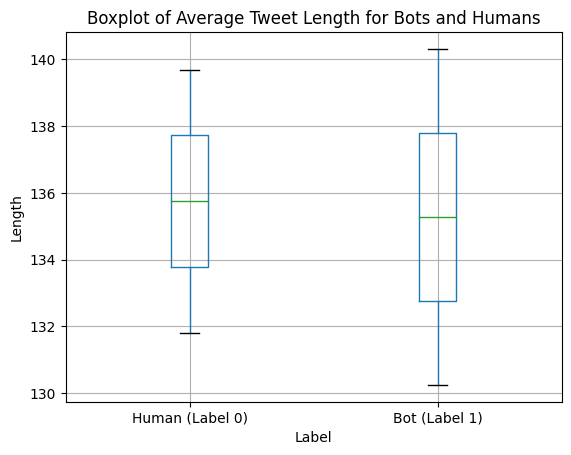

In [15]:
# Grouping data
grouped = users_df.groupby('label')['avg_tweet_length'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Average Tweet Length for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

Average Tweet Length has similar distributions between Humans and Bots. Therefore, it is not a good discerning feature in this case. The internal algorithms of XGBoost or Random Forest may not have reflected this feature importance accurately.

**Through our EDA, we would be eliminating this as an important feature.**

# 3.2 Mention Max Tweets

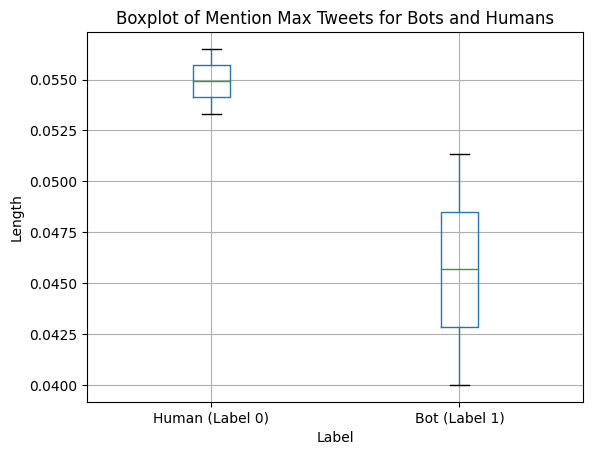

In [16]:
# Grouping data
grouped = users_df.groupby('label')['mention_max_tweets'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Mention Max Tweets for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

There is a clear distinction in distribution between Mention Max Tweets between Human and Bot, with Humans having a median of about 0.0550 while Bots have a median of about 0.0460. Humans also have a much smaller variance than Bots in this aspect.

**Hence, this correlates with the models and Mention Max Tweets will be considered an important factor.**

# 3.3 Hashtags Max Tweets

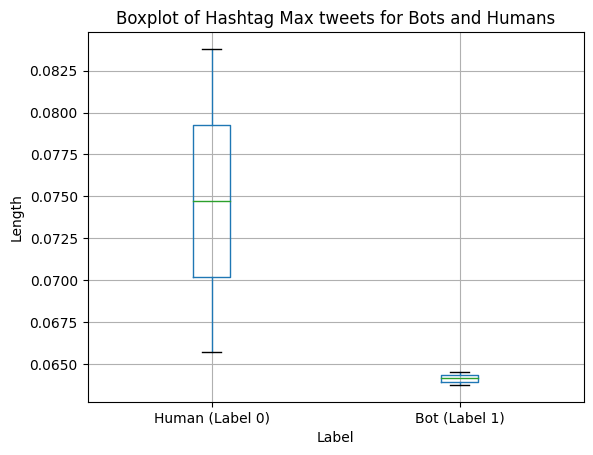

In [17]:
# Grouping data
grouped = users_df.groupby('label')['hashtags_max_tweets'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Hashtag Max tweets for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

There is a clear distinction in distribution between Hashtag Max Tweets between Human and Bot, with Humans having a median of about 0.0750 while Bots have a median of lower than 0.0650. Humans also have a much larger variance than Bots in this aspect.

**Hence, this correlates with the models and Hashtag Max Tweets will be considered an important factor.**

# 3.4 Retweet Ratio

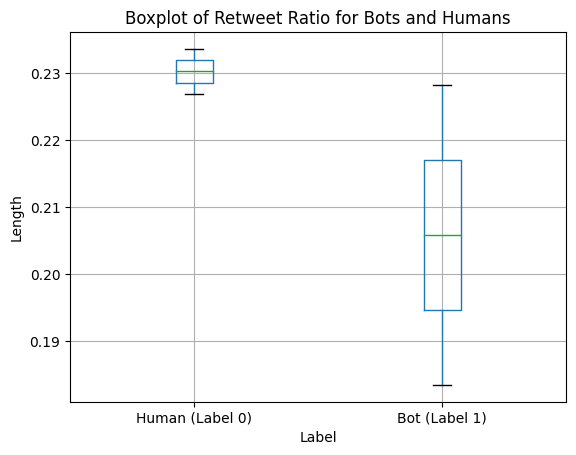

In [18]:
# Grouping data
grouped = users_df.groupby('label')['retweet_ratio'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Retweet Ratio for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

There is a clear distinction in distribution between Retweet Ratio between Human and Bot, with Humans having a median of about 0.23 while Bots have a median of about 0.205. Humans also have a much smaller variance than Bots in this aspect.

**Hence, this correlates with the models and Retweet Ratio will be considered an important factor.**

#3.5 URL Tweet Count

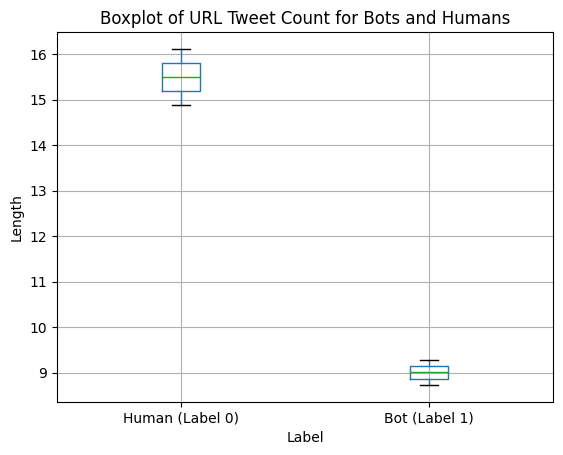

In [19]:
# Grouping data
grouped = users_df.groupby('label')['url_tweet_count'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of URL Tweet Count for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

There is a clear distinction in distribution between URL Tweet Count between Human and Bot, with Humans having a median of about 15.5 while Bots have a median of about 9.0.


**Hence, this correlates with the models and URL Tweet Count will be considered an important factor.**

# 3.6 Hashtag Count Tweets

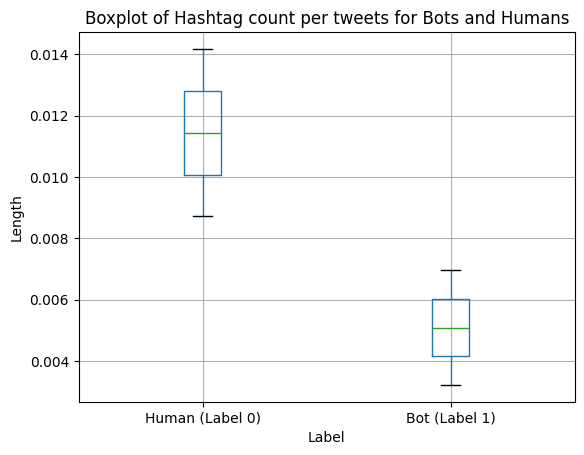

In [20]:
# Grouping data
grouped = users_df.groupby('label')['hashtag_count_tweets'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Hashtag count per tweets for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

There is a clear distinction in distribution between Hashtag Count per Tweet between Human and Bot, with Humans having a median of about 0.011 while Bots have a median of about 0.005.

**Hence, this correlates with the models and Hashtag Count per Tweet between will be considered an important factor.**

# 3.7 Tweet Count

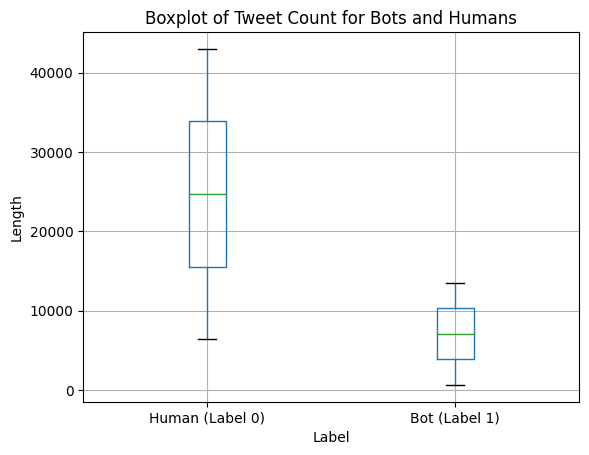

In [21]:
# Grouping data
grouped = users_df.groupby('label')['tweet_count'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Tweet Count for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

There is a clear distinction in distribution between Tweet Count between Human and Bot, with Humans having a median of about 0.0550 while Bots have a median of about 0.0460. Humans also have a much larger variance than Bots in this aspect.

**Hence, this correlates with the models and Tweet Count will be considered an important factor.**

# 3.8 Time Interval SD Day


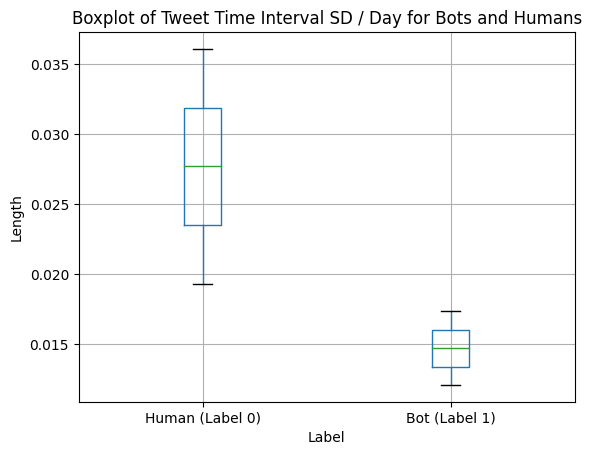

In [22]:
# Grouping data
grouped = users_df.groupby('label')['time_interval_sd_day'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Tweet Time Interval SD / Day for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

There is a clear distinction in distribution between Tweet Time Interval SD / Day between Human and Bot, with Humans having a median of about 0.0275 while Bots have a median of about 0.015. Humans also have a much larger variance than Bots in this aspect.

**Hence, this correlates with the models and Tweet Time Interval SD / Day will be considered an important factor.**

# 3.9 Follower Count

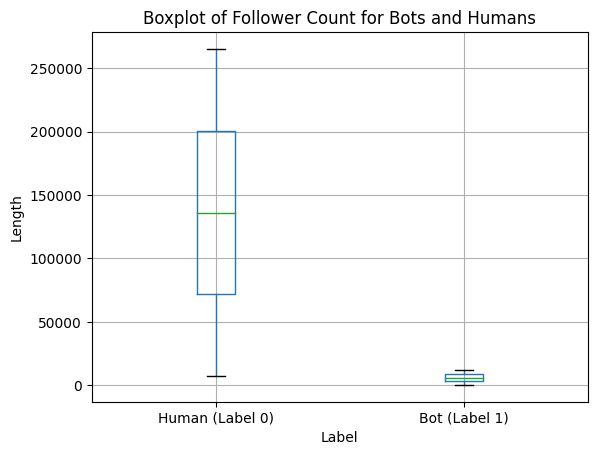

In [23]:
# Grouping data
grouped = users_df.groupby('label')['followers_count'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Follower Count for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

There is a clear distinction in distribution between Follower Count between Human and Bot, with Humans having a median of about 140000 while Bots have a median of less than 10000. Humans also have a much larger variance than Bots in this aspect.

**Hence, this correlates with the models and Follower Count will be considered an important factor.**

# 3.10 URL Ratio

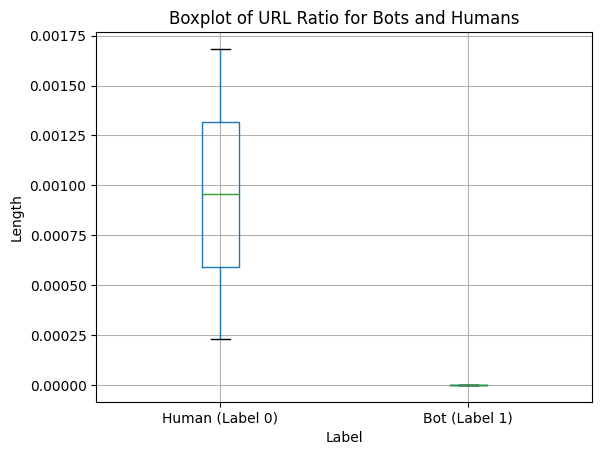

In [24]:
# Grouping data
grouped = users_df.groupby('label')['url_ratio'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of URL Ratio for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])

plt.show()

In [25]:
label_1_data = users_df.loc[users_df['label'] == 1]
mean_url_ratio_label_1 = label_1_data['url_ratio'].median()

print("Bot Median URL Ratio")
print(mean_url_ratio_label_1)

Bot Median URL Ratio
0.0


There is a clear distinction in distribution between URL Ratio between Human and Bot, with Humans having a median of about 0.00100 while Bots have a median of less than 0.001. Humans also have a much larger variance than Bots in this aspect.

**This correlates with the models. However, the median Bot values of less than 0.001 indicates that many bots have very small values. Hence, we would not be taking this factor into account as it may cause a NaN loop when training the GCN.**

# 3.11 Verified

<Figure size 800x600 with 0 Axes>

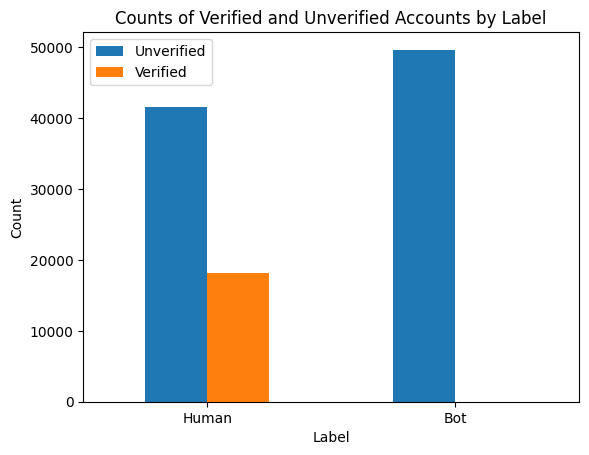

In [26]:
# Checking if verified
verified_counts = users_df.groupby(['label', 'verified']).size()


pivot_df = verified_counts.unstack()

# Plotting
plt.figure(figsize=(8, 6))

# Plot side by side bar chart
pivot_df.plot(kind='bar', stacked=False)

# Add labels and legend
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of Verified and Unverified Accounts by Label')
plt.xticks([0, 1], ['Human', 'Bot'], rotation = 0)
plt.legend(['Unverified', 'Verified'])

# Show plot
plt.show()

**There is a clear difference in count of verified users between Humans and Bots, with virtually no bots having the verified status. Hence, this is an important feature which we will include in our GCN.**

# 3.12 Listed Count

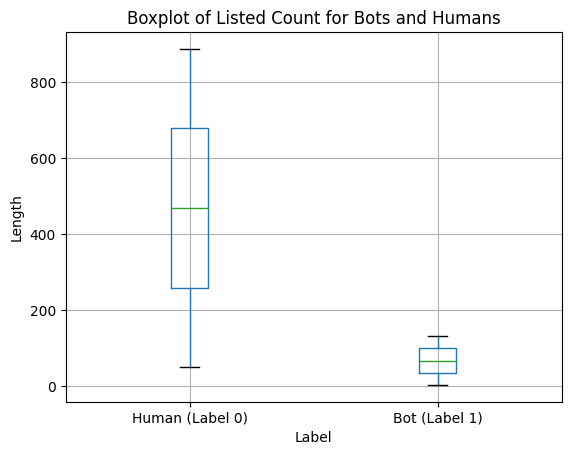

In [27]:
# Grouping data
grouped = users_df.groupby('label')['listed_count'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Listed Count for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

There is a clear distinction in distribution in listed count between Human and Bot, with Humans having a median of about 500 while Bots have a median of about 100. Humans also have a much larger variance than Bots in this aspect.

**Hence, this correlates with the models and Listed Count will be considered an important factor.**

# 3.13 Description Length

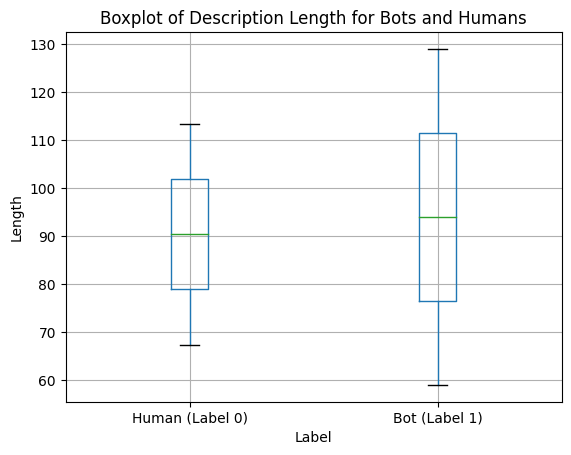

In [28]:
# Grouping data
grouped = users_df.groupby('label')['description_length'].agg(['mean', 'median'])

# Plotting as boxplot
grouped.boxplot()
plt.ylabel('Length')
plt.xlabel('Label')
plt.title('Boxplot of Description Length for Bots and Humans')
plt.xticks([1, 2], ['Human (Label 0)', 'Bot (Label 1)'])


plt.show()

Similar to Average Tweet Length, the Description Length distributions between Humans and Bots are very similar. Hence, the RF and XGboost models may have inaccurately classified them as important factors.

**Therefore, we would not be including them as an important feature.**

## Conclusion
Based on the 13 feature overlaps between the 3 feature selection methods, we have found that 10 of which aligns well based on the data exploration. 3 of which have been left out due to

The following features will be used for our subsequent Graph Based Model
1.   `mention_max_tweets`
2.   `hashtags_max_tweets`
3.   `retweet_ratio`
4.   `hashtag_count_tweets`
5.   `url_tweet_count`
6.   `tweet_count`
7.   `time_interval_sd_day`
8.   `followers_count`
9.   `verified`
10.   `listed_count`

The following features will not be used for our subsequent Graph Based Model
1.  `avg_tweet_length`
2.  `url_ratio`
3.  `description_length`